In [1]:
!pip -q install numpy pandas soundfile librosa tensorflow tqdm

In [2]:
# 1. 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

# 2. 압축 파일 복사 (드라이브 -> VM 로컬)
!cp /content/drive/MyDrive/raw_data.zip /content/

# 3. 압축 해제
!unzip -q /content/raw_data.zip -d /content/dataset

Mounted at /content/drive


## 셀 2: zip 해제 (BASE는 /content/work)

In [3]:
from pathlib import Path
import zipfile

ZIP_PATH = Path("/content/drive/MyDrive/raw_data.zip")  # 효민님 실제 경로로 수정
WORKDIR = Path("/content/work")
WORKDIR.mkdir(parents=True, exist_ok=True)

if not any(WORKDIR.iterdir()):
    print("Extracting zip...")
    with zipfile.ZipFile(ZIP_PATH, "r") as z:
        z.extractall(WORKDIR)
    print("Done extract.")
else:
    print("WORKDIR not empty, skip extract.")

BASE = WORKDIR
print("BASE =", BASE)
print("BASE dirs:", [p.name for p in BASE.iterdir() if p.is_dir()])


Extracting zip...
Done extract.
BASE = /content/work
BASE dirs: ['esc-50', 'MS-SNSD-NOISE', 'sneeze', 'recordings']


## 셀 3: 구조 체크

In [4]:
from pathlib import Path

paths = {
    "sneeze": BASE / "sneeze",
    "esc_audio": BASE / "esc-50" / "audio",
    "esc_meta": BASE / "esc-50" / "meta" / "esc50.csv",
    "ms_snsd": BASE / "MS-SNSD-NOISE",
    "recordings": BASE / "recordings",
    "noise1": BASE / "recordings" / "noise1.wav",
    "noise2": BASE / "recordings" / "noise2.wav",
    "dish": BASE / "recordings" / "dish.wav",
    "talk": BASE / "recordings" / "talk.wav",
}

for k, p in paths.items():
    print(k, "->", p, "| exists:", p.exists())


sneeze -> /content/work/sneeze | exists: True
esc_audio -> /content/work/esc-50/audio | exists: True
esc_meta -> /content/work/esc-50/meta/esc50.csv | exists: True
ms_snsd -> /content/work/MS-SNSD-NOISE | exists: True
recordings -> /content/work/recordings | exists: True
noise1 -> /content/work/recordings/noise1.wav | exists: True
noise2 -> /content/work/recordings/noise2.wav | exists: True
dish -> /content/work/recordings/dish.wav | exists: True
talk -> /content/work/recordings/talk.wav | exists: True


## 셀 4: 스펙/하이퍼파라미터 확정

In [5]:
SR = 16000
CLIP_SECONDS = 2.0
CLIP_SAMPLES = int(SR * CLIP_SECONDS)

N_MELS = 64
N_FFT = 400
HOP = 160

# 데이터 생성 규모(시간 충분하면 더 키워도 됨)
N_TRAIN = 30000
N_VAL   = 6000
N_TEST  = 6000

POS_RATIO = 0.25  # 1:3

# positive 합성 규칙
POS_BG_PROB = 0.8
POS_SNR_MIN, POS_SNR_MAX = 0.0, 20.0

# negative 합성 규칙(네거티브 내부)
NEG_EVENT_ONLY_PROB = 0.50
NEG_EVENT_BG_PROB   = 0.40
NEG_BG_ONLY_PROB    = 0.10
assert abs(NEG_EVENT_ONLY_PROB + NEG_EVENT_BG_PROB + NEG_BG_ONLY_PROB - 1.0) < 1e-9

NEG_SNR_MIN, NEG_SNR_MAX = -5.0, 10.0

# 증강
GAIN_MIN, GAIN_MAX = 0.3, 1.2
REVERB_P_POS = 0.30
REVERB_P_NEG = 0.40
SHIFT_MAX_FRAC = 0.60

print("OK config")


OK config


## 셀 5: 유틸 함수(리버브 적용 여부 레시피 0/1 기록 가능)

In [6]:
import random
import numpy as np
import pandas as pd
import soundfile as sf
import librosa
from pathlib import Path

AUDIO_EXTS = {".wav", ".flac", ".mp3", ".ogg", ".m4a", ".aac"}

def list_audio_files(root: Path):
    files = []
    for p in root.rglob("*"):
        if p.is_file() and p.suffix.lower() in AUDIO_EXTS:
            files.append(p)
    return files

def load_audio(path: Path, sr: int = SR) -> np.ndarray:
    y, file_sr = sf.read(str(path), always_2d=False)
    if isinstance(y, np.ndarray) and y.ndim > 1:
        y = y.mean(axis=1)
    y = np.asarray(y, dtype=np.float32)
    y = np.nan_to_num(y)
    if file_sr != sr:
        y = librosa.resample(y, orig_sr=file_sr, target_sr=sr).astype(np.float32)
    return y

def rms(x: np.ndarray, eps: float = 1e-8) -> float:
    return float(np.sqrt(np.mean(x * x) + eps))

def normalize_rms(y: np.ndarray, target_rms: float = 0.1) -> np.ndarray:
    r = rms(y)
    if r > 1e-6:
        y = y * (target_rms / (r + 1e-8))
    return np.clip(y, -1.0, 1.0).astype(np.float32)

def crop_or_pad(y: np.ndarray, target_len: int, rng: random.Random) -> np.ndarray:
    if len(y) >= target_len:
        start = rng.randint(0, len(y) - target_len)
        return y[start:start + target_len]
    pad = target_len - len(y)
    left = rng.randint(0, pad)
    right = pad - left
    return np.pad(y, (left, right), mode="constant")

def time_shift_roll(y: np.ndarray, shift_samples: int) -> np.ndarray:
    return np.roll(y, shift_samples).astype(np.float32)

def set_snr(fg: np.ndarray, bg: np.ndarray, snr_db: float) -> np.ndarray:
    fg_r = rms(fg)
    bg_r = rms(bg)
    if bg_r < 1e-6:
        return fg
    k = fg_r / (bg_r * (10 ** (snr_db / 20.0)))
    return (fg + k * bg).astype(np.float32)

def apply_reverb(y: np.ndarray, rng: random.Random) -> np.ndarray:
    ir_len = rng.randint(int(0.03 * SR), int(0.12 * SR))
    t = np.arange(ir_len, dtype=np.float32)
    decay = rng.uniform(8.0, 25.0)
    ir = np.exp(-t / (SR / decay)).astype(np.float32)
    ir[0] = 1.0
    ir = ir / (np.sum(ir) + 1e-8)
    out = np.convolve(y, ir, mode="full")[:len(y)]
    return out.astype(np.float32)

def logmel(y: np.ndarray) -> np.ndarray:
    S = librosa.feature.melspectrogram(
        y=y, sr=SR, n_fft=N_FFT, hop_length=HOP, n_mels=N_MELS, power=2.0
    )
    S = np.log(S + 1e-6).astype(np.float32)
    return S.T  # (frames, mels)


## 셀 6: 파일 풀 생성 + “소스 파일 단위” 3-way split

In [7]:
import random
from pathlib import Path

SNEEZE_DIR = BASE / "sneeze"
ESC_AUDIO_DIR = BASE / "esc-50" / "audio"
ESC_META_CSV = BASE / "esc-50" / "meta" / "esc50.csv"
NOISE_DIR = BASE / "MS-SNSD-NOISE"
REC_DIR = BASE / "recordings"

def load_esc50_negative_events(meta_csv: Path, audio_dir: Path):
    df = pd.read_csv(meta_csv)
    df = df[df["category"].str.lower() != "sneezing"]
    files = [audio_dir / fn for fn in df["filename"].tolist()]
    files = [p for p in files if p.exists()]
    if len(files) == 0:
        raise RuntimeError("ESC-50 네거티브 이벤트 파일 0개. esc50.csv 경로/포맷 확인.")
    return files

def split_files_3way(files, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, seed=123):
    rng = random.Random(seed)
    files = list(files)
    rng.shuffle(files)
    n = len(files)
    n_train = max(1, int(n * train_ratio))
    n_val = max(1, int(n * val_ratio))
    train = files[:n_train]
    val = files[n_train:n_train+n_val]
    test = files[n_train+n_val:]
    if len(test) == 0:
        test = val[-1:]
        val = val[:-1]
    return train, val, test

# pools
pos_files = list_audio_files(SNEEZE_DIR)
esc_neg_files = load_esc50_negative_events(ESC_META_CSV, ESC_AUDIO_DIR)

noise1 = REC_DIR / "noise1.wav"
noise2 = REC_DIR / "noise2.wav"
dish = REC_DIR / "dish.wav"
talk = REC_DIR / "talk.wav"

for p in [noise1, noise2, dish, talk]:
    if not p.exists():
        raise RuntimeError(f"필수 파일 없음: {p}")

neg_event_files = esc_neg_files + [noise1, noise2]
bg_files = list_audio_files(NOISE_DIR) + [dish, talk]

# split all pools by file
pos_tr, pos_va, pos_te = split_files_3way(pos_files, 0.8, 0.1, 0.1, seed=1)
neg_ev_tr, neg_ev_va, neg_ev_te = split_files_3way(neg_event_files, 0.8, 0.1, 0.1, seed=2)
bg_tr, bg_va, bg_te = split_files_3way(bg_files, 0.8, 0.1, 0.1, seed=3)

print("pos files:", len(pos_files), "train/val/test:", len(pos_tr), len(pos_va), len(pos_te))
print("neg event files:", len(neg_event_files), "train/val/test:", len(neg_ev_tr), len(neg_ev_va), len(neg_ev_te))
print("bg files:", len(bg_files), "train/val/test:", len(bg_tr), len(bg_va), len(bg_te))


pos files: 968 train/val/test: 774 96 98
neg event files: 1962 train/val/test: 1569 196 197
bg files: 130 train/val/test: 104 13 13


## 셀 7: split별 샘플 생성 + 레시피 저장(진행바)

In [8]:
from tqdm.auto import tqdm
from pathlib import Path
import numpy as np
import random

OUTDIR = Path("/content/work/datasets")
OUTDIR.mkdir(parents=True, exist_ok=True)

def make_one_sample(label, pools, seed):
    rng = random.Random(seed)

    recipe = {
        "seed": int(seed),
        "label": int(label),
        "type": "",
        "fg_path": "",
        "bg_path": "",
        "snr_db": np.nan,
        "gain": np.nan,
        "reverb": 0,           # 0/1
        "shift_samples": 0,
    }

    shift_samples = rng.randint(0, int(SHIFT_MAX_FRAC * CLIP_SAMPLES))
    recipe["shift_samples"] = int(shift_samples)

    gain = rng.uniform(GAIN_MIN, GAIN_MAX)
    recipe["gain"] = float(gain)

    if label == 1:
        fg_path = rng.choice(pools["pos_files"])
        recipe["fg_path"] = str(fg_path)

        fg = load_audio(fg_path)
        fg = crop_or_pad(fg, CLIP_SAMPLES, rng)
        fg = time_shift_roll(fg, shift_samples)
        fg = normalize_rms(fg)

        if rng.random() < POS_BG_PROB:
            bg_path = rng.choice(pools["bg_files"])
            recipe["bg_path"] = str(bg_path)

            snr_db = rng.uniform(POS_SNR_MIN, POS_SNR_MAX)
            recipe["snr_db"] = float(snr_db)

            bg = load_audio(bg_path)
            bg = crop_or_pad(bg, CLIP_SAMPLES, rng)
            bg = normalize_rms(bg)

            mixed = set_snr(fg, bg, snr_db)
            recipe["type"] = "pos_bg"
        else:
            mixed = fg
            recipe["type"] = "pos_clean"

        mixed = (mixed * gain).astype(np.float32)
        apply = (rng.random() < REVERB_P_POS)
        recipe["reverb"] = 1 if apply else 0
        if apply:
            mixed = apply_reverb(mixed, rng)

        mixed = normalize_rms(mixed)
        feat = logmel(mixed)
        return feat, 1, recipe

    # negative
    r = rng.random()
    if r < NEG_EVENT_ONLY_PROB:
        fg_path = rng.choice(pools["neg_event_files"])
        recipe["fg_path"] = str(fg_path)

        ev = load_audio(fg_path)
        ev = crop_or_pad(ev, CLIP_SAMPLES, rng)
        ev = time_shift_roll(ev, shift_samples)
        ev = normalize_rms(ev)

        mixed = ev
        recipe["type"] = "neg_event"

    elif r < NEG_EVENT_ONLY_PROB + NEG_EVENT_BG_PROB:
        fg_path = rng.choice(pools["neg_event_files"])
        bg_path = rng.choice(pools["bg_files"])
        recipe["fg_path"] = str(fg_path)
        recipe["bg_path"] = str(bg_path)

        ev = load_audio(fg_path)
        ev = crop_or_pad(ev, CLIP_SAMPLES, rng)
        ev = time_shift_roll(ev, shift_samples)
        ev = normalize_rms(ev)

        bg = load_audio(bg_path)
        bg = crop_or_pad(bg, CLIP_SAMPLES, rng)
        bg = normalize_rms(bg)

        snr_db = rng.uniform(NEG_SNR_MIN, NEG_SNR_MAX)
        recipe["snr_db"] = float(snr_db)

        mixed = set_snr(ev, bg, snr_db)
        recipe["type"] = "neg_event_bg"

    else:
        bg_path = rng.choice(pools["bg_files"])
        recipe["bg_path"] = str(bg_path)

        bg = load_audio(bg_path)
        bg = crop_or_pad(bg, CLIP_SAMPLES, rng)
        bg = time_shift_roll(bg, shift_samples)
        bg = normalize_rms(bg)

        mixed = bg
        recipe["type"] = "neg_bg"

    mixed = (mixed * gain).astype(np.float32)
    apply = (rng.random() < REVERB_P_NEG)
    recipe["reverb"] = 1 if apply else 0
    if apply:
        mixed = apply_reverb(mixed, rng)

    mixed = normalize_rms(mixed)
    feat = logmel(mixed)
    return feat, 0, recipe

def build_split_npz(out_path: Path, n_samples: int, pools, seed_base: int):
    X, Y = [], []

    stype, fg_path, bg_path = [], [], []
    snr_db, gain, reverb, shift_samples, seed_arr = [], [], [], [], []

    for i in tqdm(range(n_samples), desc=f"Build {out_path.name}"):
        # 라벨 결정도 seed 기반으로 고정
        is_pos = (random.Random(seed_base * 10_000 + i).random() < POS_RATIO)
        seed = seed_base * 1_000_000 + i

        feat, yy, rec = make_one_sample(1 if is_pos else 0, pools, seed)

        X.append(feat); Y.append(yy)
        stype.append(rec["type"])
        fg_path.append(rec["fg_path"])
        bg_path.append(rec["bg_path"])
        snr_db.append(rec["snr_db"])
        gain.append(rec["gain"])
        reverb.append(int(rec["reverb"]))
        shift_samples.append(int(rec["shift_samples"]))
        seed_arr.append(int(rec["seed"]))

    X = np.stack(X, axis=0).astype(np.float32)
    Y = np.asarray(Y, dtype=np.int64)

    np.savez_compressed(
        out_path,
        X=X,
        y=Y,
        stype=np.asarray(stype, dtype=object),
        fg_path=np.asarray(fg_path, dtype=object),
        bg_path=np.asarray(bg_path, dtype=object),
        snr_db=np.asarray(snr_db, dtype=np.float32),
        gain=np.asarray(gain, dtype=np.float32),
        reverb=np.asarray(reverb, dtype=np.int64),
        shift_samples=np.asarray(shift_samples, dtype=np.int64),
        seed=np.asarray(seed_arr, dtype=np.int64),
        sr=SR,
        clip_seconds=CLIP_SECONDS,
        n_mels=N_MELS,
        n_fft=N_FFT,
        hop=HOP,
    )
    print("saved:", out_path, "X:", X.shape, "y:", Y.shape, "pos:", int((Y==1).sum()), "neg:", int((Y==0).sum()))

pools_train = {"pos_files": pos_tr, "neg_event_files": neg_ev_tr, "bg_files": bg_tr}
pools_val   = {"pos_files": pos_va, "neg_event_files": neg_ev_va, "bg_files": bg_va}
pools_test  = {"pos_files": pos_te, "neg_event_files": neg_ev_te, "bg_files": bg_te}

train_raw_path = OUTDIR / "train_2s_raw.npz"
val_raw_path   = OUTDIR / "val_2s_raw.npz"
test_raw_path  = OUTDIR / "test_2s_raw.npz"

build_split_npz(train_raw_path, N_TRAIN, pools_train, seed_base=11)
build_split_npz(val_raw_path,   N_VAL,   pools_val,   seed_base=22)
build_split_npz(test_raw_path,  N_TEST,  pools_test,  seed_base=33)


Build train_2s_raw.npz:   0%|          | 0/30000 [00:00<?, ?it/s]

saved: /content/work/datasets/train_2s_raw.npz X: (30000, 201, 64) y: (30000,) pos: 7507 neg: 22493


Build val_2s_raw.npz:   0%|          | 0/6000 [00:00<?, ?it/s]

saved: /content/work/datasets/val_2s_raw.npz X: (6000, 201, 64) y: (6000,) pos: 1509 neg: 4491


Build test_2s_raw.npz:   0%|          | 0/6000 [00:00<?, ?it/s]

saved: /content/work/datasets/test_2s_raw.npz X: (6000, 201, 64) y: (6000,) pos: 1511 neg: 4489


## 셀 8: train 통계로 정규화 후 저장(3개)

In [9]:
import numpy as np
from pathlib import Path

def load_npz(path: Path):
    return np.load(path, allow_pickle=True)

train_raw = load_npz(train_raw_path)
val_raw   = load_npz(val_raw_path)
test_raw  = load_npz(test_raw_path)

Xtr = train_raw["X"].astype(np.float32)
mu = Xtr.mean(axis=(0,1), keepdims=True)
sd = Xtr.std(axis=(0,1), keepdims=True) + 1e-6

stats_path = OUTDIR / "norm_stats.npz"
np.savez_compressed(stats_path, mu=mu.astype(np.float32), sd=sd.astype(np.float32))
print("saved:", stats_path)

def apply_norm_save(raw_npz, out_path: Path, mu, sd):
    X = raw_npz["X"].astype(np.float32)
    Xn = (X - mu) / sd
    np.savez_compressed(
        out_path,
        X=Xn.astype(np.float32),
        y=raw_npz["y"].astype(np.int64),
        stype=raw_npz["stype"],
        fg_path=raw_npz["fg_path"],
        bg_path=raw_npz["bg_path"],
        snr_db=raw_npz["snr_db"].astype(np.float32),
        gain=raw_npz["gain"].astype(np.float32),
        reverb=raw_npz["reverb"].astype(np.int64),
        shift_samples=raw_npz["shift_samples"].astype(np.int64),
        seed=raw_npz["seed"].astype(np.int64),
        mu=mu.astype(np.float32),
        sd=sd.astype(np.float32),
        sr=raw_npz["sr"],
        clip_seconds=raw_npz["clip_seconds"],
        n_mels=raw_npz["n_mels"],
        n_fft=raw_npz["n_fft"],
        hop=raw_npz["hop"],
    )
    print("saved:", out_path)

train_path = OUTDIR / "train_2s.npz"
val_path   = OUTDIR / "val_2s.npz"
test_path  = OUTDIR / "test_2s.npz"

apply_norm_save(train_raw, train_path, mu, sd)
apply_norm_save(val_raw,   val_path,   mu, sd)
apply_norm_save(test_raw,  test_path,  mu, sd)


saved: /content/work/datasets/norm_stats.npz
saved: /content/work/datasets/train_2s.npz
saved: /content/work/datasets/val_2s.npz
saved: /content/work/datasets/test_2s.npz


## 셀 9: 데이터 로드(train/val/test)

In [10]:
import numpy as np

train = np.load(train_path, allow_pickle=True)
val   = np.load(val_path, allow_pickle=True)
test  = np.load(test_path, allow_pickle=True)

X_train = train["X"][..., None].astype(np.float32)
y_train = train["y"].astype(np.int64)

X_val = val["X"][..., None].astype(np.float32)
y_val = val["y"].astype(np.int64)

X_test = test["X"][..., None].astype(np.float32)
y_test = test["y"].astype(np.int64)

print("train:", X_train.shape, "pos:", int((y_train==1).sum()), "neg:", int((y_train==0).sum()))
print("val  :", X_val.shape,   "pos:", int((y_val==1).sum()),   "neg:", int((y_val==0).sum()))
print("test :", X_test.shape,  "pos:", int((y_test==1).sum()),  "neg:", int((y_test==0).sum()))


train: (30000, 201, 64, 1) pos: 7507 neg: 22493
val  : (6000, 201, 64, 1) pos: 1509 neg: 4491
test : (6000, 201, 64, 1) pos: 1511 neg: 4489


## 셀 10: 모델 정의 + 학습

In [11]:
import tensorflow as tf
import numpy as np

def make_model(frames: int, mels: int):
    inp = tf.keras.Input(shape=(frames, mels, 1))
    x = inp
    for ch in [16, 24, 32, 48]:
        x = tf.keras.layers.SeparableConv2D(ch, (3,3), padding="same", use_bias=False)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.MaxPool2D((2,2))(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    out = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    return tf.keras.Model(inp, out)

model = make_model(X_train.shape[1], X_train.shape[2])
model.summary()

pos = int((y_train == 1).sum())
neg = int((y_train == 0).sum())
ratio = neg / max(pos, 1)
class_weight = {0: 1.0, 1: min(3.0, max(1.0, ratio * 0.5))}
print("class_weight:", class_weight, "neg/pos:", ratio)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc"),
    ],
)

hist = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    class_weight=class_weight,
    verbose=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_precision", mode="max", patience=3, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5),
    ],
)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 201, 64, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 201, 64, 16)    │            25 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 201, 64, 16)    │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 201, 64, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 100, 32, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 100, 32, 24)    │           528 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100, 32, 24)    │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 100, 32, 24)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 50, 16, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_2              │ (None, 50, 16, 32)     │           984 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 50, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 50, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 8, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_3              │ (None, 25, 8, 48)      │         1,824 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 25, 8, 48)      │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 25, 8, 48)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 4, 48)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 48)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            49 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 3,890 (15.20 KB)

 Trainable params: 3,650 (14.26 KB)

 Non-trainable params: 240 (960.00 B)

class_weight: {0: 1.0, 1: 1.4981350739309978} neg/pos: 2.9962701478619955
Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - auc: 0.7156 - loss: 0.6496 - precision: 0.4550 - recall: 0.4392 - val_auc: 0.7995 - val_loss: 0.5778 - val_precision: 0.4593 - val_recall: 0.7634 - learning_rate: 0.0010
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - auc: 0.8553 - loss: 0.5033 - precision: 0.6606 - recall: 0.6161 - val_auc: 0.8908 - val_loss: 0.3560 - val_precision: 0.7415 - val_recall: 0.5646 - learning_rate: 0.0010
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - auc: 0.8788 - loss: 0.4655 - precision: 0.6843 - recall: 0.6502 - val_auc: 0.8661 - val_loss: 0.4197 - val_precision: 0.8104 - val_recall: 0.4135 - learning_rate: 0.0010
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - auc: 0.8908 - loss: 0.4422 - precision: 0.7062 - recall: 0.6807 - val_auc: 0.8998 - val_loss: 0.3415 - val_precision: 0.7542 - val_recall: 0.5898 - learning_rate: 0.0010
Epoch 5/30
469/469 ━━━━━━

## 셀 11: threshold 결정(val) + 혼동행렬(val/test)

47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step
chosen_th(from val): 0.9711445783132531
VAL metrics: {'precision': 1.0, 'recall': 0.06494367130550033, 'f1': 0.12196639701306783, 'accuracy': 0.7648333333333334, 'fpr': 0.0, 'tp': 98, 'fp': 0, 'tn': 4491, 'fn': 1411}


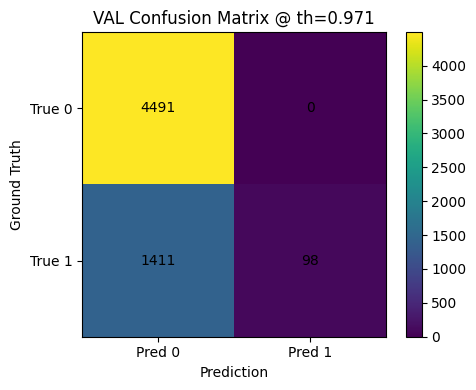

VAL: {'precision': 1.0, 'recall': 0.06494367130550033, 'f1': 0.12196639701306783, 'accuracy': 0.7648333333333334, 'fpr': 0.0, 'tp': 98, 'fp': 0, 'tn': 4491, 'fn': 1411}
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


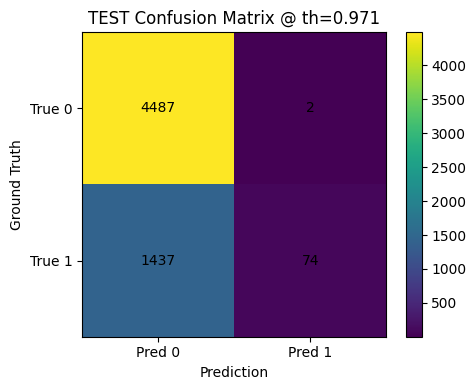

TEST: {'precision': 0.9736842105263158, 'recall': 0.04897418927862343, 'f1': 0.09325771896660366, 'accuracy': 0.7601666666666667, 'fpr': 0.00044553352639786146, 'tp': 74, 'fp': 2, 'tn': 4487, 'fn': 1437}


In [12]:
import numpy as np
import matplotlib.pyplot as plt

def confusion_and_metrics(y_true, y_prob, th):
    y_pred = (y_prob >= th).astype(int)
    tp = int(((y_pred==1) & (y_true==1)).sum())
    fp = int(((y_pred==1) & (y_true==0)).sum())
    tn = int(((y_pred==0) & (y_true==0)).sum())
    fn = int(((y_pred==0) & (y_true==1)).sum())

    precision = tp / max(tp + fp, 1)
    recall    = tp / max(tp + fn, 1)
    f1        = (2*precision*recall) / max(precision + recall, 1e-9)
    acc       = (tp + tn) / max(tp + tn + fp + fn, 1)
    fpr       = fp / max(fp + tn, 1)

    cm = np.array([[tn, fp],
                   [fn, tp]], dtype=int)
    return cm, {"precision": precision, "recall": recall, "f1": f1, "accuracy": acc, "fpr": fpr,
                "tp": tp, "fp": fp, "tn": tn, "fn": fn}

def plot_confusion(cm, title):
    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    plt.xticks([0,1], ["Pred 0", "Pred 1"])
    plt.yticks([0,1], ["True 0", "True 1"])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(cm[i, j]), ha="center", va="center")
    plt.xlabel("Prediction")
    plt.ylabel("Ground Truth")
    plt.tight_layout()
    plt.show()

val_prob = model.predict(X_val, batch_size=128, verbose=1).reshape(-1)

best = None
for th in np.linspace(0.5, 0.995, 250):
    _, m = confusion_and_metrics(y_val, val_prob, float(th))
    score = (m["fp"], -m["recall"])
    if best is None or score < best[0]:
        best = (score, float(th), m)

chosen_th = best[1]
print("chosen_th(from val):", chosen_th)
print("VAL metrics:", best[2])

cm_val, m_val = confusion_and_metrics(y_val, val_prob, chosen_th)
plot_confusion(cm_val, f"VAL Confusion Matrix @ th={chosen_th:.3f}")
print("VAL:", m_val)

test_prob = model.predict(X_test, batch_size=128, verbose=1).reshape(-1)
cm_test, m_test = confusion_and_metrics(y_test, test_prob, chosen_th)
plot_confusion(cm_test, f"TEST Confusion Matrix @ th={chosen_th:.3f}")
print("TEST:", m_test)


## 셀 12: 오탐 샘플 export(wav) — 레시피의 reverb 0/1 그대로 적용

In [13]:
import tensorflow as tf
from pathlib import Path
import shutil

OUT = Path("/content/work/out")
OUT.mkdir(parents=True, exist_ok=True)

keras_path = OUT / "sneeze_ds_cnn.keras"
tflite_path = OUT / "sneeze_ds_cnn_dynamic.tflite"
stats_path = OUT / "norm_stats.npz"
th_path = OUT / "threshold.txt"

model.save(str(keras_path))

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
tflite_path.write_bytes(tflite_model)

shutil.copy2(OUTDIR / "norm_stats.npz", stats_path)
th_path.write_text(f"{chosen_th}\n")

print("saved:", keras_path)
print("saved:", tflite_path)
print("saved:", stats_path)
print("saved:", th_path)

DRIVE_OUT = Path("/content/drive/MyDrive/sneeze_project_out")
DRIVE_OUT.mkdir(parents=True, exist_ok=True)

for f in [keras_path, tflite_path, stats_path, th_path]:
    shutil.copy2(f, DRIVE_OUT / f.name)
    print("copied ->", DRIVE_OUT / f.name)


Saved artifact at '/tmp/tmpk3ph6n1n'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 201, 64, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  135158021027792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135158021027984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135157867823952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135158021028944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135157867824528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135157867823376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135157867825104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135157867825488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135157867824336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135157867825680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135158021029136